In [1]:
import numpy as np
import os
from math import ceil
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split, KFold
from keras.utils.vis_utils import plot_model
from keras import layers, models, optimizers
from keras.initializers import he_normal, lecun_normal
from keras import backend as K
import keras
import warnings

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tqdm import tqdm_notebook as tqdm


warnings.filterwarnings('ignore')

In [2]:
TESTING=False

SQUARE_SIZE = 40#must be less than 400/8==50
train_size = 3000
test_size = 500
BATCH_SIZE= 128
SEED=2019
Epoch=100
k_folds=5
PATIENCE=5
if TESTING:
    train_size=2000
    test_size=100
    BATCH_SIZE=64
    SEED=SEED
    Epoch=2
    k_folds=3
    PATIENCE=2

In [ ]:
#Kindly download dataset from link as it is in GB's from link https://www.kaggle.com/datasets/koryakinp/chess-positions

In [3]:
#including data and using train and test data set
DATA_PATH='C:/Users/goldu/Downloads/chessfengen'
TRAIN_IMAGE_PATH=os.path.join(DATA_PATH, 'train')
TEST_IMAGE_PATH=os.path.join(DATA_PATH, 'test')

In [4]:
# With glob we take all global paths and enable easy path tracing
def get_image_filenames(image_path, image_type):
    if(os.path.exists(image_path)):
        return glob.glob(os.path.join(image_path, '*.'+image_type))
    return

In [5]:
#getting train and test dataset
train = get_image_filenames(TRAIN_IMAGE_PATH, "jpeg")
test = get_image_filenames(TEST_IMAGE_PATH, "jpeg")

#we shuffule in randome manner 
random.shuffle(train)
random.shuffle(test)

train = train[:train_size]
test = test[:test_size]

#black symbol pieces are small and white symbol pieces are capital
piece_symbols = 'prbnkqPRBNKQ'

In [6]:
#here we get the file name path for individial file so that we can include it further
def fen_from_filename(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

In [7]:
def get_image_filenames(image_path, image_type):
    if(os.path.exists(image_path)):
        return glob.glob(os.path.join(image_path, '*.'+image_type))
    return

In [8]:
# here we take 1000 training data set images to convert it to FEN format
for i in range (1000):
    print(fen_from_filename(train[i]))

2k1N3-8-8-5b2-1K5Q-8-2n5-8
5B2-pP3r2-b2q4-q6P-K7-2P1k1R1-3p1p2-4B3
6R1-5b2-5r2-1B6-8-bN2BB2-P3kP2-1K3n2
1K6-8-8-8-3P3k-6p1-4B3-8
5b1N-4r3-1b6-KN6-3B4-1B5p-4B3-1B2k3
8-8-1r1p4-8-R5P1-5rk1-4K3-Q7
3R4-5b2-5R2-p1Br2r1-2K3k1-8-8-2b5
4k2R-6P1-8-3n4-8-8-2K5-8
4N1Q1-7k-5P2-2Kp4-2Q5-8-3R2p1-3q4
2K5-8-8-1nk1Q3-5R2-8-4Bp2-3q3b
8-r4R2-1K6-6k1-5q2-4Q2n-8-8
8-2p5-8-1KR5-8-3b4-r4B1P-1n5k
8-1Q2p3-Q7-6N1-8-r7-4k3-2K5
K2N4-Pr4r1-2nk4-1P6-8-8-1Bq5-R3q3
3r4-3pB3-2Pq4-5b2-1P2p3-2K2P2-5kp1-4N1n1
8-6P1-4k3-1rK5-2N2n2-8-8-8
N7-8-4B2r-2p3K1-3p4-8-7k-6b1
1r5k-5NB1-2bK3r-8-2p1P3-4b3-P7-7N
8-8-2b5-8-5p2-1KN5-8-7k
1n6-KBB3b1-3N1pQ1-3p4-4k3-bNR5-8-q2B4
3R4-2r2p2-K1bb2B1-8-1Q1P1P2-3B3p-4p3-3b3k
5B2-6BN-8-8-1p3K2-5p2-2B5-7k
4B3-8-3K4-4P3-p6r-4q1p1-8-2BBk3
3b4-2Q5-8-8-8-2k5-K7-1B6
8-b7-8-3n2n1-8-8-8-3K3k
8-P3n1B1-8-6k1-8-P3Rr2-5P1R-3NBK1b
6rr-6rp-6r1-8-B1K2p1B-3n4-2k5-r3R3
8-3P4-B2P3P-1K6-Q1Q5-Bk6-1q6-8
8-8-8-2r3b1-8-4k3-2KB4-8
8-3n3N-8-8-1K4b1-7p-2n5-2k2b2
1n6-2p5-1P5k-8-BnQ2B2-1q5B-1Kp5-2b5
1B6-p6k-8-1b6-8-8-8-3B2K1

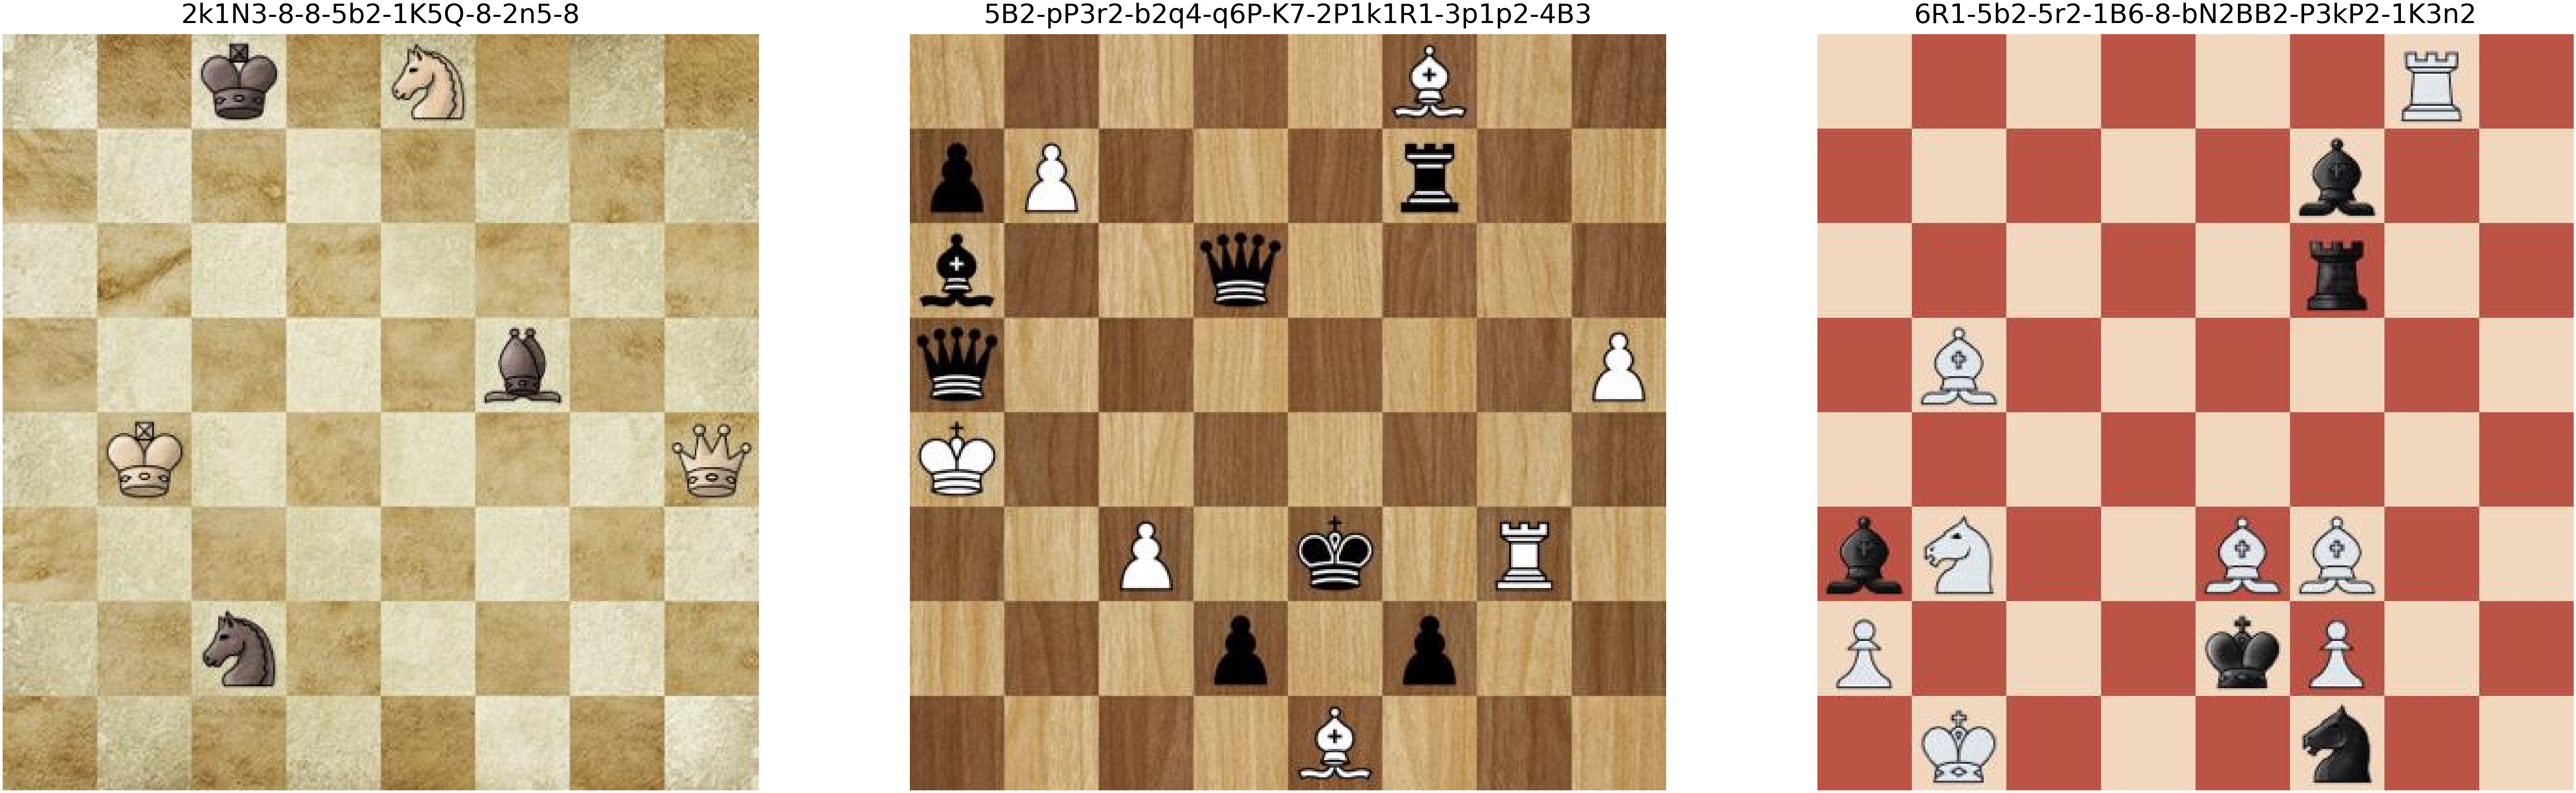

In [9]:
f, axarr = plt.subplots(1,3, figsize=(120, 120))
#if you change the range to 0 to 1000 the images will be with fen code of that image 
for i in range(0,3):
    axarr[i].set_title(fen_from_filename(train[i]), fontsize=70, pad=30)
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')

In [ ]:
# one hot encoding ro convert and utlise it to check accuracy of model
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output
# as 64 squares and all chess boards and 8 lines per line of squares
def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [11]:
#starting preprocessing from scratch to detect accuracy

def process_image(img):
    downsample_size = SQUARE_SIZE*8
    square_size = SQUARE_SIZE
    img_read = io.imread(img)
    img_read = transform.resize(img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

In [12]:
#onehotencoder used to convert fen 
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [13]:
#training model by batchsize which we can change later
def train_gen(features, batch_size):
    i=0
    while True:
        batch_x=[]
        batch_y=[]
        for b in range(batch_size):
            if i==len(features):
                i=0
                random.shuffle(features)
            img=str(features[i])
            y = onehot_from_fen(fen_from_filename(img))
            x = process_image(img)
            for x_part in x:
                batch_x.append(x_part)
            for y_part in y:
                batch_y.append(y_part)
            i+=1
        yield (np.array(batch_x), np.array(batch_y))
#predicting next move for AI part
        
def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

In [14]:
#processing image to square size toi get image from fen and along with it

def process_image(img):
    downsample_size = SQUARE_SIZE*8
    square_size = SQUARE_SIZE
    img_read = io.imread(img)
    img_read = transform.resize(img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

In [15]:
#calback to all other functions
def get_callbacks(model_name, patient):
    ES = EarlyStopping(
        monitor='val_loss', 
        patience=patient, 
        mode='min', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='min')
    MC = ModelCheckpoint(
        filepath=model_name, 
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        mode='min')

    return [ES, RR, MC]

In [16]:
#Weighted loss function used for the variable with weights which use keras for future use. Also, use categorical data like labels just in case
def weighted_categorical_crossentropy(weights):
    
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [17]:
#here we get the model name and image size, model name is the model like weight loss for further use of accuracy model
def get_model(image_size):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(image_size, image_size, 3)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(13, activation='softmax', kernel_initializer='lecun_normal'))
    
#    model.summary()
    
    weights=np.array([1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1,  1/(0.10*4), 1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1,  1/(0.10*4), 1/(64-10)])
    model.compile(loss=weighted_categorical_crossentropy(weights), optimizer='nadam', metrics=['acc'])#weight the inverse of expected pieces
    
    return model

In [18]:
#keras fold for further model summary
kf = KFold(n_splits=k_folds, random_state=SEED, shuffle = True)

In [19]:
j = 1
model_names=[]
for (train_fold, valid_fold) in kf.split(train):
    print("=========================================")
    print("====== K Fold Validation step => %d/%d =======" % (j,k_folds))
    print("=========================================")
    
    model_name = '../'+ str(j) + '.hdf5'
    model_names.append(model_name)
    model=get_model(SQUARE_SIZE)
    
    history=model.fit_generator(train_gen([train[i] for i in tqdm(train_fold)], batch_size=2), steps_per_epoch=ceil(train_size*(1-1/k_folds)/2), epochs=Epoch, validation_data=train_gen([train[i] for i in tqdm(valid_fold)], batch_size
    =2), validation_steps=ceil(train_size/k_folds/2), verbose=1, shuffle=False, callbacks=get_callbacks(model_name, PATIENCE))
    j+=1#single batch is actually 64*batch_size, since there are 64 pieces on the board

====== K Fold Validation step => 1/5 =======


  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/100
1200/1200 [==============================] - 860s 715ms/step - loss: 0.0434 - acc: 0.9425 - val_loss: 0.0059 - val_acc: 0.9987

Epoch 00001: val_loss improved from inf to 0.00588, saving model to ..\1.hdf5
Epoch 2/100
1200/1200 [==============================] - 819s 683ms/step - loss: 0.0033 - acc: 0.9955 - val_loss: 7.4450e-04 - val_acc: 0.9999

Epoch 00002: val_loss improved from 0.00588 to 0.00074, saving model to ..\1.hdf5
Epoch 3/100
1200/1200 [==============================] - 842s 702ms/step - loss: 0.0015 - acc: 0.9997 - val_loss: 3.7142e-05 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00074 to 0.00004, saving model to ..\1.hdf5
Epoch 4/100
1200/1200 [==============================] - 828s 690ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 2.3874e-04 - val_acc: 0.9999

Epoch 00004: val_loss did not improve from 0.00004
Epoch 5/100
1200/1200 [==============================] - 814s 678ms/step - loss: 0.0053 - acc: 0.9939 - val_loss: 1.8071e-04 - val_acc:

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/100
1200/1200 [==============================] - 1453s 1s/step - loss: 0.0494 - acc: 0.9307 - val_loss: 0.0023 - val_acc: 0.9996

Epoch 00001: val_loss improved from inf to 0.00231, saving model to ..\2.hdf5
Epoch 2/100
1200/1200 [==============================] - 1308s 1s/step - loss: 0.0042 - acc: 0.9957 - val_loss: 0.0054 - val_acc: 0.9984

Epoch 00002: val_loss did not improve from 0.00231
Epoch 3/100
1200/1200 [==============================] - 1228s 1s/step - loss: 0.0093 - acc: 0.9840 - val_loss: 0.0034 - val_acc: 0.9991

Epoch 00003: val_loss did not improve from 0.00231
Epoch 4/100
1200/1200 [==============================] - 1241s 1s/step - loss: 0.0013 - acc: 0.9984 - val_loss: 4.3190e-05 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00231 to 0.00004, saving model to ..\2.hdf5
Epoch 5/100
1200/1200 [==============================] - 1018s 849ms/step - loss: 0.0012 - acc: 0.9996 - val_loss: 3.9320e-04 - val_acc: 1.0000

Epoch 00005: val_loss did not improve

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/100
 160/1200 [===>..........................] - ETA: 15:44 - loss: 0.2244 - acc: 0.6188

KeyboardInterrupt: 

In [ ]:
#sorry for incovience my machine is ot euipped to run all of it as it takes alot of time

In [ ]:
# thus cannot run forward code for model accuracy though you can on your machine, so following functions are giving erross.

In [20]:
for name in tqdm(model_names):
    res = (
      (keras.models.load_model(name, custom_objects={'loss':weighted_categorical_crossentropy(np.array([1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1,  1/(0.10*4), 1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1,  1/(0.10*4), 1/(64-10)]))})).predict_generator(pred_gen(test, 64), steps=test_size)
      .argmax(axis=1)
      .reshape(-1, 8, 8)
    )
    pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
    test_fens = np.array([fen_from_filename(fn) for fn in test])
    
    final_accuracy = (pred_fens == test_fens).astype(float).mean()
    
    print("Model Name: ", name, "Final Accuracy: {:1.5f}%".format(final_accuracy))

  0%|          | 0/3 [00:00<?, ?it/s]

Model Name:  ../1.hdf5 Final Accuracy: 1.00000%
Model Name:  ../2.hdf5 Final Accuracy: 1.00000%


OSError: SavedModel file does not exist at: ../3.hdf5\{saved_model.pbtxt|saved_model.pb}

In [26]:
#since above code is not fully executed, thus this code is not fully executed, i put my machine for 12 hours 
#buts its still this probl

In [21]:
def load_all_models(names):
    models=[]
    for model_name in names:
        models.append(keras.models.load_model(model_name, custom_objects={'loss':weighted_categorical_crossentropy(np.array([1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1,  1/(0.10*4), 1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1,  1/(0.10*4), 1/(64-10)]))}))
    return models

In [22]:
def get_stacked_model(models):
    input_layer=keras.layers.Input(shape=(SQUARE_SIZE, SQUARE_SIZE, 3,))
    xs=[model(input_layer) for model in models]
    out=keras.layers.Add()(xs)
    
    model=keras.models.Model(inputs=[input_layer], outputs=out)
    return model

In [23]:
model=get_stacked_model(load_all_models(model_names))

OSError: SavedModel file does not exist at: ../3.hdf5\{saved_model.pbtxt|saved_model.pb}

In [24]:
#testing model
res_stacked = (
  model.predict_generator(pred_gen(test, 64), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

In [25]:
#accuracy
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res_stacked])
test_fens = np.array([fen_from_filename(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.70000%


In [27]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

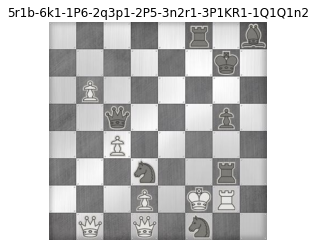

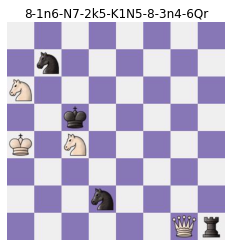

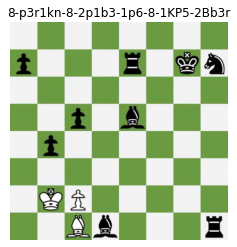

In [28]:
display_with_predicted_fen(test[0])
display_with_predicted_fen(test[1])
display_with_predicted_fen(test[2])